# GloVe vectors for sentiment analysis

## Sentiment Analysis

**Sentiment Analysis** is the problem of identifying the writer's sentiment given a piece of text.
Sentiment Analysis can be applied to movie reviews, feedback of other forms, emails, tweets, 
course evaluations, and much more.

Rudimentary forms of **sentiment analysis** might involve scoring each
word on a scale from "sad" to "happy", then averaging the "happiness score" of each
word in a piece of text. This technique has obvious drawbacks: it won't be able to handle
negation, sarcasm, or any complex syntactical form. We can do better.
In fact, we will use the sentiment analysis task as an example in the next few
lectures.

Today, we'll focus on the problem of classifying tweets as having positive or negative
emotions. We use the Sentiment140 data set, which contains tweets with either a positive
or negative emoticon. Our goal is to determine whether which type of
emoticon the tweet (with the emoticon removed) contained. The dataset was actually collected by
a group of students, just like you, who are doing their first machine learning project,
just like you will be soon.

You can download the data here: http://help.sentiment140.com/

Let's look at the data:

In [3]:
import csv

def get_data():
    return csv.reader(open("training.1600000.processed.noemoticon.csv", 
                           "rt", encoding="latin-1"))

for i, line in enumerate(get_data()):
    if line[0] != '0':
        print(line[0], line[-1])
        break

4 I LOVE @Health4UandPets u guys r the best!! 


The columns we care about is the first one and the last one. The first column is the
label (the label `0` means "sad" tweet, `4` means "happy" tweet), and the last column
contains the tweet. Our task is to predict the sentiment of the tweet given the text.

The approach today is as follows, for each tweet:

1. We will split the text into words. We will do so by splitting at all whitespace
   characters. There are better ways to perform the split, but let's keep our
   dependencies light.
2. We will look up the GloVe embedding of each word.
   Words that do not have a GloVe vector will be ignored.
3. We will sum up all the embeddings, to get an embedding for an entire tweet.
4. Finally, we will use a fully-connected neural network (a **multi-layer peceptron** or MLP)
   to predict whether the tweet has positive or negative sentiment.

First, let's sanity check that there are enough words for us to work with.

In [8]:
split_tweet("hello, this is don't")

['hello', ',', 'this', 'is', "don't"]

In [9]:
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50)

def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

# verify that each tweet has a reasonable number of words
# that has GloVe embeddings
for i, line in enumerate(get_data()):
    if i > 30:
        break
    print(sum(int(w in glove.stoi) for w in split_tweet(line[-1])))

21
23
17
10
22
4
3
21
4
3
9
4
19
15
19
18
18
4
9
13
11
23
8
9
4
11
13
6
23
20
13


Looks like each tweet has at least one word that has an embedding.

Now, steps 1-3 from above can be done ahead of time, just like the transfer learning
portion of Lab 3. So, we will write a function that will take the tweets data
file, computes the tweet embeddings, and splits the data into train/validation/test.

We will only use $\frac{1}{59}$ of the data in the file, so that this demo runs
relatively quickly.

In [10]:
import torch
import torch.nn as nn

def get_tweet_vectors(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        tweet = line[-1]
        if i % 59 == 0:
            # obtain an embedding for the entire tweet
            tweet_emb = sum(glove_vector[w] for w in split_tweet(tweet))
            # generate a label: 1 = happy, 0 = sad
            label = torch.tensor(int(line[0] == "4")).long()
            # place the data set in either the training, validation, or test set
            if i % 5 < 3:
                train.append((tweet_emb, label)) # 60% training
            elif i % 5 == 4:
                valid.append((tweet_emb, label)) # 20% validation
            else:
                test.append((tweet_emb, label)) # 20% test
    return train, valid, test

I'm making the `glove_vector` a parameter so that we can test the effect
of using a higher dimensional GloVe
embedding later. Now, let's get our training, validation, and test set.
The format is what `torch.utils.data.DataLoader` expects.

In [11]:
import torchtext

glove = torchtext.vocab.GloVe(name="6B", dim=50)

train, valid, test = get_tweet_vectors(glove)

train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

Now, our actual training script! Note that will we use `CrossEntropyLoss`,
have two neurons in the final layer of our output layer, and use softmax instead of
a sigmoid activation. This is different from our choice in the earlier weeks!
Typically, machine learning practitioners will choose to use two output
neurons instead of one, even in a binary classification task. The reason is that
an extra neuron adds some more parameters to the network, and makes the network
a little easier to train (performs better).

In [12]:
import matplotlib.pyplot as plt

def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train_loader:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            
        losses.append(float(loss))     
        if epoch % 5 == 4:
            epochs.append(epoch)
            train_acc.append(get_accuracy(model, train_loader))
            valid_acc.append(get_accuracy(model, valid_loader))
            print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

As for the actual mode, we will start with a 3-layer neural network.
We won't create our own class since this is a fairly straightforward neural
network, so an `nn.Sequential` object will do. 
Let's build and train our network.

Epoch 5; Loss 0.578561; Train Acc 0.645566; Val Acc 0.648414
Epoch 10; Loss 0.687417; Train Acc 0.660439; Val Acc 0.662611
Epoch 15; Loss 0.500862; Train Acc 0.669658; Val Acc 0.673857
Epoch 20; Loss 0.625540; Train Acc 0.675189; Val Acc 0.676991
Epoch 25; Loss 0.661380; Train Acc 0.673099; Val Acc 0.673673
Epoch 30; Loss 0.713764; Train Acc 0.676603; Val Acc 0.674226
Epoch 35; Loss 0.567966; Train Acc 0.680659; Val Acc 0.676254
Epoch 40; Loss 0.415750; Train Acc 0.681212; Val Acc 0.677360
Epoch 45; Loss 0.570576; Train Acc 0.681704; Val Acc 0.676438
Epoch 50; Loss 0.753588; Train Acc 0.684162; Val Acc 0.677913
Epoch 55; Loss 0.632546; Train Acc 0.686006; Val Acc 0.678097
Epoch 60; Loss 0.509674; Train Acc 0.686313; Val Acc 0.677360
Epoch 65; Loss 0.617104; Train Acc 0.690062; Val Acc 0.677544
Epoch 70; Loss 0.579414; Train Acc 0.687972; Val Acc 0.676069
Epoch 75; Loss 0.422985; Train Acc 0.690062; Val Acc 0.675701
Epoch 80; Loss 0.622142; Train Acc 0.691414; Val Acc 0.676807
Epoch 85;

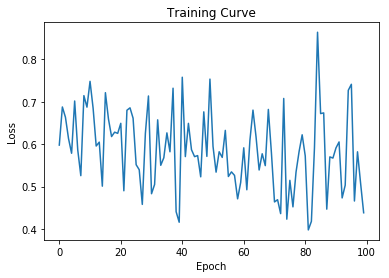

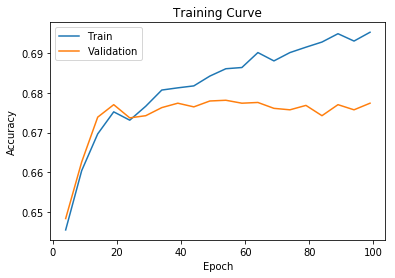

Final test accuracy: 0.6769911504424779


In [13]:
mymodel = nn.Sequential(nn.Linear(50, 30),
                        nn.ReLU(),
                        nn.Linear(30, 10),
                        nn.ReLU(),
                        nn.Linear(10, 2))
train_network(mymodel, train_loader, valid_loader, num_epochs=100, learning_rate=1e-4)
print("Final test accuracy:", get_accuracy(mymodel, test_loader))

In [14]:
def test_model(model, glove_vector, tweet):
    emb = sum(glove_vector[w] for w in split_tweet(tweet))
    out = mymodel(emb.unsqueeze(0))
    pred = out.max(1, keepdim=True)[1]
    return pred

test_model(mymodel, glove, "very happy")

tensor([[1]])

In [15]:
test_model(mymodel, glove, "This is a terrible tragedy")

tensor([[0]])

In [18]:
test_model(mymodel, glove, "the midterm will be great :)")

tensor([[1]])

In [19]:
test_model(mymodel, glove, "the midterm will be bad :)")

tensor([[0]])

In [20]:
test_model(mymodel, glove, "go raptors")

tensor([[1]])

In [23]:
test_model(mymodel, glove, "okay")

tensor([[0]])

Note that the model does not perform very well at all, and still
misclassify about one third of tweets in the test set.
Just for fun, we can try a smaller neural network, even one with just a single layer.

Epoch 5; Loss 0.883092; Train Acc 0.496773; Val Acc 0.491888
Epoch 10; Loss 0.960001; Train Acc 0.542560; Val Acc 0.534661
Epoch 15; Loss 0.949360; Train Acc 0.587548; Val Acc 0.576512
Epoch 20; Loss 0.663996; Train Acc 0.619015; Val Acc 0.610619
Epoch 25; Loss 0.550363; Train Acc 0.637269; Val Acc 0.641777
Epoch 30; Loss 0.608798; Train Acc 0.648516; Val Acc 0.650996
Epoch 35; Loss 0.465200; Train Acc 0.653002; Val Acc 0.660767
Epoch 40; Loss 0.619334; Train Acc 0.659640; Val Acc 0.662979
Epoch 45; Loss 0.604713; Train Acc 0.663389; Val Acc 0.664270
Epoch 50; Loss 0.555910; Train Acc 0.666708; Val Acc 0.667035
Epoch 55; Loss 0.459237; Train Acc 0.668183; Val Acc 0.669801
Epoch 60; Loss 0.656344; Train Acc 0.667998; Val Acc 0.672566
Epoch 65; Loss 0.600274; Train Acc 0.669596; Val Acc 0.671829
Epoch 70; Loss 0.736891; Train Acc 0.669166; Val Acc 0.673857
Epoch 75; Loss 0.505133; Train Acc 0.670211; Val Acc 0.674963
Epoch 80; Loss 0.479095; Train Acc 0.670518; Val Acc 0.675516
Epoch 85;

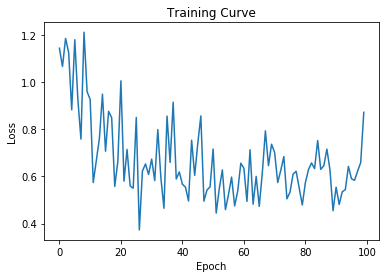

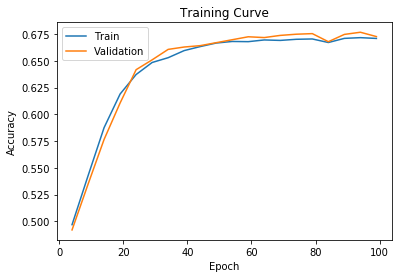

Final test accuracy: 0.6760693215339233


In [24]:
mymodel = nn.Linear(50, 2)
train_network(mymodel, train_loader, valid_loader, num_epochs=100, learning_rate=1e-4)
print("Final test accuracy:", get_accuracy(mymodel, test_loader))

We don't have to stick to a 50-dimensional GloVe embedding.
To build a potentially stronger model, we can choose a larger GloVe embedding.
However, to get really good accuracy, we are better for using a
a more powerful architecture.

Epoch 5; Loss 0.766563; Train Acc 0.652326; Val Acc 0.658739
Epoch 10; Loss 0.862790; Train Acc 0.676787; Val Acc 0.671645
Epoch 15; Loss 0.495216; Train Acc 0.694180; Val Acc 0.682522
Epoch 20; Loss 0.617580; Train Acc 0.703276; Val Acc 0.692294
Epoch 25; Loss 0.517584; Train Acc 0.705181; Val Acc 0.696903
Epoch 30; Loss 0.637947; Train Acc 0.708377; Val Acc 0.693584
Epoch 35; Loss 0.480883; Train Acc 0.708869; Val Acc 0.694137
Epoch 40; Loss 0.788573; Train Acc 0.715014; Val Acc 0.699299
Epoch 45; Loss 0.627466; Train Acc 0.715813; Val Acc 0.697824
Epoch 50; Loss 0.536115; Train Acc 0.716981; Val Acc 0.696718
Epoch 55; Loss 0.453820; Train Acc 0.719009; Val Acc 0.698193
Epoch 60; Loss 0.535800; Train Acc 0.720669; Val Acc 0.696903
Epoch 65; Loss 0.511547; Train Acc 0.722267; Val Acc 0.698562
Epoch 70; Loss 1.097582; Train Acc 0.723188; Val Acc 0.700774
Epoch 75; Loss 0.439176; Train Acc 0.726692; Val Acc 0.698009
Epoch 80; Loss 0.440033; Train Acc 0.724541; Val Acc 0.700590
Epoch 85;

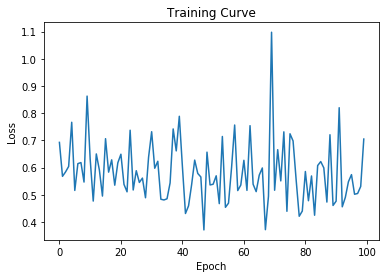

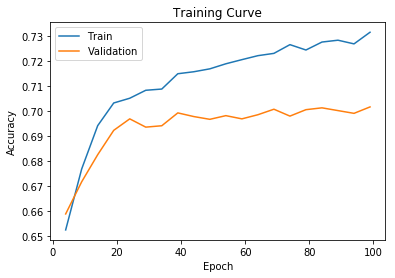

0.696165191740413

In [25]:
glove = torchtext.vocab.GloVe(name="6B", dim=100, max_vectors=20000)
train, valid, test = get_tweet_vectors(glove)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

mymodel = nn.Sequential(nn.Linear(100, 45), 
                        nn.ReLU(), 
                        nn.Linear(45, 2))
train_network(mymodel, train_loader, valid_loader, num_epochs=100, learning_rate=1e-4)
get_accuracy(mymodel, test_loader)